### 目的

根据保单信息，预测病人的风险程度。

### 变量

将成本分为五档，每一档的成本总和是总成本的20%。第一档的人占总人数的78%，但总成本只占20%，可见这一档人医疗成本低，是低风险人群。

### 误差度量

将高成本病人误分类为低成本病人，比把低成本病人误分类为高成本病人要糟糕。因此使用`penalty error`来体现这种不对称性。定义惩罚矩阵（penalty matrix）：

![惩罚矩阵](http://i3.buimg.com/b19c29d26317097a.png)

如果将病人正确预测，则惩罚为0；若将3档的病人预测为1档的，惩罚为4；反之，若将1档的病人预测为3档的，惩罚为2。惩罚矩阵体现出对“把高成本病人误分类为低成本病人”是更严重的错误（2倍的惩罚）。

### 基准模型

下一期的成本被预测为当期成本。准确度为75%，平均惩罚误差为0.56。

In [1]:
Claims = read.csv("./data/ClaimsData.csv")
str(Claims)

'data.frame':	458005 obs. of  16 variables:
 $ age              : int  85 59 67 52 67 68 75 70 67 67 ...
 $ alzheimers       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ arthritis        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ cancer           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ copd             : int  0 0 0 0 0 0 0 0 0 0 ...
 $ depression       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ diabetes         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ heart.failure    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ihd              : int  0 0 0 0 0 0 0 0 0 0 ...
 $ kidney           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ osteoporosis     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ stroke           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ reimbursement2008: int  0 0 0 0 0 0 0 0 0 0 ...
 $ bucket2008       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ reimbursement2009: int  0 0 0 0 0 0 0 0 0 0 ...
 $ bucket2009       : int  1 1 1 1 1 1 1 1 1 1 ...


处于1档的病人占病人总量的67%。

In [2]:
table(Claims$bucket2009)/nrow(Claims)


          1           2           3           4           5 
0.671267781 0.190170413 0.089466272 0.043324855 0.005770679 

目标是用CART预测`bucket2009`。

In [3]:
library(caTools)

In [4]:
set.seed(88)

In [5]:
spl = sample.split(Claims$bucket2009, SplitRati = 0.6)
train = subset(Claims, spl == TRUE)
test = subset(Claims, spl == FALSE)

### Quick Question

In [8]:
mean(train$age)

[1] 72.63773

In [15]:
table(train$diabetes)


     0      1 
170131 104672 

In [16]:
104672/(170131+104672)

[1] 0.3808983

### 基准模型

- 准确度

左侧是2009年的分组情况，上侧是2008年的分组情况。

In [17]:
table(test$bucket2009, test$bucket2008)

   
         1      2      3      4      5
  1 110138   7787   3427   1452    174
  2  16000  10721   4629   2931    559
  3   7006   4629   2774   1621    360
  4   2688   1943   1415   1539    352
  5    293    191    160    309    104

In [18]:
(110138+10721+2774+1539+104)/nrow(test)

[1] 0.6838135

- 惩罚误差

惩罚矩阵的上面是预测，左侧是实际。左下角的8表明：预测是1档（成本最低），实际是5档（成本最高），此时惩罚最严重。

In [23]:
PenaltyMatrix = matrix(c(0,1,2,3,4,2,0,1,2,3,4,2,0,1,2,6,4,2,0,1,8,6,4,2,0), byrow=TRUE, nrow=5)
PenaltyMatrix

0,1,2,3,4
2,0,1,2,3
4,2,0,1,2
6,4,2,0,1
8,6,4,2,0


向量乘而非矩阵乘：矩阵同一位置的两个元素相乘。得到惩罚矩阵。

In [24]:
as.matrix(table(test$bucket2009, test$bucket2008))*PenaltyMatrix

   
        1     2     3     4     5
  1     0  7787  6854  4356   696
  2 32000     0  4629  5862  1677
  3 28024  9258     0  1621   720
  4 16128  7772  2830     0   352
  5  2344  1146   640   618     0

基准模型的平均惩罚误差。

In [25]:
sum(as.matrix(table(test$bucket2009, test$bucket2008))*PenaltyMatrix)/nrow(test)

[1] 0.7386055

以“无论如何都预测为1档”作为基准模型：

In [26]:
table(test$bucket2009)


     1      2      3      4      5 
122978  34840  16390   7937   1057 

准确度：

In [27]:
122978/nrow(test)

[1] 0.67127

平均惩罚误差：

In [37]:
sum(as.matrix(table(test$bucket2009))*PenaltyMatrix[,1])/nrow(test)

[1] 1.044301

### 预测

In [38]:
library(rpart)
library(rpart.plot)

通过交叉验证选出cp的值。

In [39]:
ClaimsTree = rpart(bucket2009 ~ age + arthritis + alzheimers + cancer + copd + depression + diabetes + heart.failure + ihd + kidney + osteoporosis + stroke + bucket2008 + reimbursement2008, data=train, method="class", cp=0.00005)

树特别大：

- 观测值多
- 五分类

Warning message:
: labs do not fit even at cex 0.15, there may be some overplotting

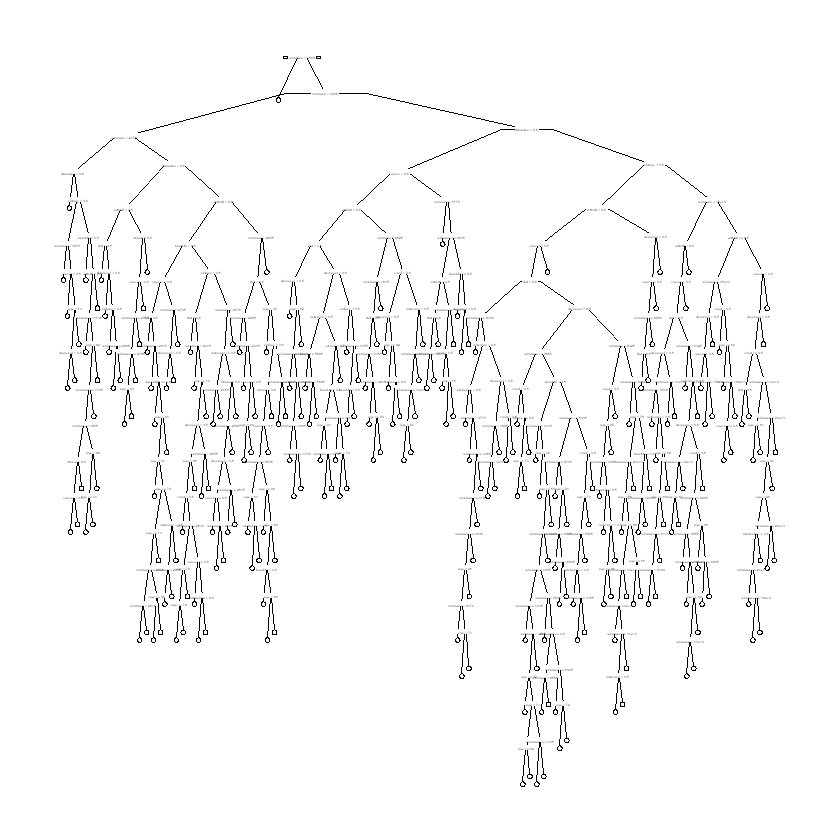

In [40]:
prp(ClaimsTree)

In [41]:
PredictTest = predict(ClaimsTree, newdata=test, type="class")
table(test$bucket2009, PredictTest)

   PredictTest
         1      2      3      4      5
  1 114141   8610    124    103      0
  2  18409  16102    187    142      0
  3   8027   8146    118     99      0
  4   3099   4584     53    201      0
  5    351    657      4     45      0

准确度。

In [42]:
(114141+16102+118+201)/nrow(test)

[1] 0.7126669

平均惩罚误差。

In [43]:
sum(as.matrix(table(test$bucket2009, PredictTest))*PenaltyMatrix)/nrow(test)

[1] 0.7578902

比“以08年的分组情况作为09年分组情况的预测值”基准模型的准确度（0.68->0.71）和平均惩罚误差（0.74->0.76）都高了。原因在于，CART试图最大化整体准确度，**每一类误差的惩罚都被视为1**。而CART模型很少预测3,4和5，因为属于3,4,5档的样本就很少。因此，CART模型会受到比较多的惩罚（容易出现把高风险病人分类为低风险病人的误分类），因此并不指望它的平均惩罚误差很低。

修正方法是加入作为惩罚依据的自定义的惩罚矩阵，`parms=list(loss=PenaltyMatrix)`：

In [44]:
ClaimsTree = rpart(bucket2009 ~ age + arthritis + alzheimers + cancer + copd + depression + diabetes + heart.failure + ihd + kidney + osteoporosis + stroke + bucket2008 + reimbursement2008, data=train, method="class", cp=0.00005, parms=list(loss=PenaltyMatrix))

In [45]:
PredictTest = predict(ClaimsTree, newdata=test, type="class")
table(test$bucket2009, PredictTest)

   PredictTest
        1     2     3     4     5
  1 94310 25295  3087   286     0
  2  7176 18942  8079   643     0
  3  3590  7706  4692   401     1
  4  1304  3193  2803   636     1
  5   135   356   408   156     2

果不其然，准确度和平均惩罚误差都变低了。

In [46]:
(94310+18942+4692+636+2)/nrow(test)

[1] 0.6472746

In [47]:
sum(as.matrix(table(test$bucket2009, PredictTest))*PenaltyMatrix)/nrow(test)

[1] 0.6418161